In [1]:
import tensorflow as tf
import cv2
print(tf.__version__)
import time
import skimage
import os
from generator.u_net_generator_v2 import UNetGenerator
# from source.preprocessing import *
import tensorflow_datasets as tfds
from discriminator.patch_resnet_discriminator import PatchResnetDiscriminator
from source.loss import disc_binary_cross_entropy, gen_l1_loss, gen_feature_matching, gen_binary_cross_entropy, disc_log_loss, \
  gen_log_loss, loss_hinge_dis, loss_hinge_gen

2.0.0-beta1


In [2]:
IMG_SIZE = 384
PATCH_SIZE = 128
BATCH_SIZE = 32
BUFFER_SIZE = 64
EPOCHS=20

In [3]:
def rgb_to_gray(image):
  return tf.image.rgb_to_grayscale(image), image

def yuv2rgb(image):
  image = tf.image.yuv_to_rgb(image)
  image = tf.clip_by_value(image,clip_value_min=0, clip_value_max=1)
  return image

def random_resize(image):
  print(image[0])
  H, W = image.shape[:2]
  scale = tf.random.uniform([], minval=0.8, maxval=1.2, dtype=tf.float32, seed=None, name=None)
  shape = tf.stack((scale * W, scale * H), axis=0)
  shape = tf.cast(shape, tf.int32)
  image = tf.image.resize(image, size=shape)
  return image

# normalizing the images to [-1, 1]
def normalize(input_image, target_image):
  input_image = (input_image / 127.5) - 1
  target_image = (target_image / 127.5) - 1
  return input_image, target_image

def random_noise(input, target):
  bound = 1. / 128
  input += tf.random.uniform(shape=input.shape, minval=-bound, maxval=bound)
  return input, target

def process_tfds(features, HEIGHT, WIDTH):
  image = features["image"]
  image = tf.image.resize_with_crop_or_pad(image, target_height=HEIGHT, target_width=WIDTH)
  return image


def random_crop(image, HEIGHT, WIDTH, CHANNELS=3):
  image = tf.image.random_crop(image, size=[HEIGHT, WIDTH, CHANNELS])
  return image

def random_flip(image):
  return tf.image.random_flip_left_right(image)

def rgb2yuv(image):
  image =  tf.image.rgb_to_yuv(image/255)
  return image

def normalize_yuv(image):
  return image[..., 0:1]  / 0.5 - 1, tf.concat([image[..., 0:1] / 0.5 - 1, image[..., 1:]], axis=-1)

In [4]:
def rgb2lab(image):
    assert image.dtype == 'float32', "Wrong dtype:" + image.dtype
    image = cv2.cvtColor(np.array(image, np.float32)/255, cv2.COLOR_RGB2LAB)
    
    l_channel,a_channel,b_channel = cv2.split(image)
    l_channel = np.expand_dims((l_channel / 50) - 1, axis=3)
    a_channel = np.expand_dims(a_channel / 127, axis=3)
    b_channel = np.expand_dims(b_channel / 127, axis=3)
    
    image = np.concatenate((l_channel,a_channel,b_channel),axis=-1)
    return tf.cast(image, tf.float32)

# def lab_channel_split(lab_image):
#     assert lab_image.dtype == 'float32', "Wrong dtype:" + lab_image.dtype
#     l_channel,a_channel,b_channel = cv2.split(np.array(lab_image)/255.)
#     l_channel = np.expand_dims(l_channel, axis=3)
#     a_channel = np.expand_dims(a_channel, axis=3)
#     b_channel = np.expand_dims(b_channel, axis=3)
#     return l_channel, tf.concat((a_channel,b_channel),axis=-1)

def lab_normalizer(L_batch):
    # Input is a normalized lab image
    return (L_batch / 50) - 1, AB_batch / 128.

def lab2rgb(image):
    # convert LAB image to RGB color space
    # rgb2lab: Input range: [0,100] x [-128,128] x [-128,128]
    # Output range (RGB): [0,1]x[0,1]x[0,1]
    return color.lab2rgb(image)

In [5]:
def tf_lab_split_channels(lab_image):
    return lab_image[...,0:1], lab_image[...,1:]

In [6]:
train_dataset = tfds.load(name="coco2014", split=tfds.Split.ALL)
train_dataset = train_dataset.map(lambda x: process_tfds(x, IMG_SIZE, IMG_SIZE))
train_dataset = train_dataset.map(random_resize)
train_dataset = train_dataset.map(lambda x: random_crop(x, PATCH_SIZE, PATCH_SIZE))
train_dataset = train_dataset.map(random_flip)
train_dataset = train_dataset.map(
    lambda x: tuple(tf.py_function(rgb2lab, [x], [tf.float32])))


# train_dataset = train_dataset.map(lab_normalizer)
# train_dataset = train_dataset.map(
#     lambda x: tuple(tf.py_function(lab_channel_split, [x], [tf.float32,tf.float32])))
# train_dataset = train_dataset.map(lab_normalizer)
train_dataset = train_dataset.map(tf_lab_split_channels)
train_dataset = train_dataset.repeat(1)
train_dataset = train_dataset.shuffle(32)
train_dataset = train_dataset.batch(BATCH_SIZE)

Tensor("strided_slice:0", shape=(384, 3), dtype=uint8)


In [7]:
# Hinge Loss
def loss_hinge_dis(dis_fake, dis_real):
  loss = tf.reduce_mean(tf.nn.relu(1. - dis_real))
  loss += tf.reduce_mean(tf.nn.relu(1. + dis_fake))
  return loss

def loss_hinge_gen(dis_fake):
  loss = -tf.reduce_mean(dis_fake)
  return loss

In [8]:
def LAB_normalizer(lab_image):
    # receives batch input image in LAB color space
    # Returns tuple (Luminance, AB channels)
    batch_luminance = lab_image[...,0:1]
    batch_luminance = (batch_luminance / 50) - 1
    
    batch_ab_channels = lab_image[...,1:]
    batch_ab_channels = batch_ab_channels / 128
    
    batch_luminance = tf.cast(batch_luminance, tf.float32)
    batch_ab_channels = tf.cast(batch_ab_channels, tf.float32)
    
    return batch_luminance, batch_ab_channels

In [9]:
def batch_LAB_denorm(L_batch, AB_batch):
    assert len(L_batch.shape) == 4, "L_batch image has to be 4D"
    assert len(AB_batch.shape) == 4, "AB_batch image has to be 4D"
    
    L_batch = (L_batch + 1) * 50
    AB_batch = AB_batch * 128
    LAB_image = tf.concat([L_batch, AB_batch], axis=-1)
    return LAB_image

In [10]:
def normalize_lab_to_original_range(lab_image):
    # assume input is between -1 and 1
    lab_image = lab_image.numpy()
    lab_image[...,0] = (lab_image[...,0] + 1) * 0.5
    lab_image[...,1:] = lab_image[...,1:] * 128
    return lab_image

In [11]:
def normalize_lab_zero_to_one(lab_image):
    # assume input is between -1 and 1
    return (lab_image + 1) * 0.5

/home/thalles/anaconda3/envs/tf2.0_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  
/home/thalles/anaconda3/envs/tf2.0_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  import sys
/home/thalles/anaconda3/envs/tf2.0_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


input_image L shape: (32, 128, 128, 1)
input_image AB shape: (32, 128, 128, 2)
Channel L -1.0 1.0
Channel A -0.35968447 0.52474827
Channel B -0.43262774 0.60979754
------------------------------- CREATE LAB FROM L + AB -------------------------------
lab_image shape: (32, 128, 128, 3)
Channel L 0.0 1.0
Channel A 0.32015777 0.76237416
Channel B 0.28368613 0.80489874
------------------------------- LAB to RGB -------------------------------
Batch RGB Converted
Channel R 0.0 0.3233349
Channel G 0.0 0.024394536
Channel B 0.0 0.029538918


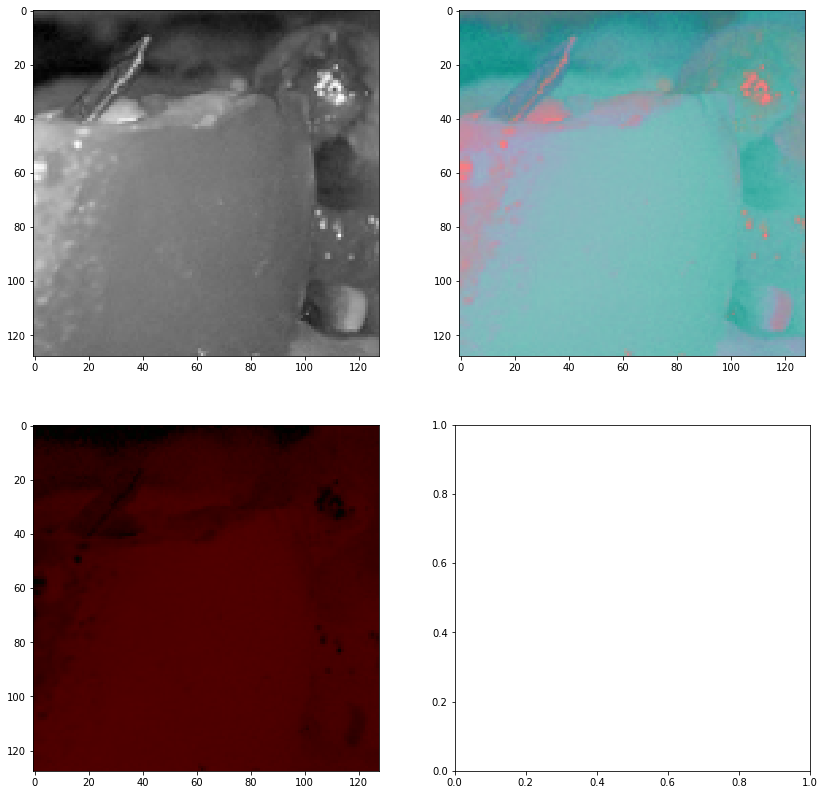

In [16]:
import matplotlib.pyplot as plt
import numpy as np

for L_batch, AB_batch in train_dataset.take(1):

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,14), constrained_layout=False)
    
    print("input_image L shape:", L_batch.shape)    
    print("input_image AB shape:", AB_batch.shape)    
    print("Channel L", np.min(L_batch), np.max(L_batch))
    print("Channel A", np.min(AB_batch[...,0]), np.max(AB_batch[...,0]))
    print("Channel B", np.min(AB_batch[...,1]), np.max(AB_batch[...,1]))
    
    ax1.imshow(tf.squeeze((L_batch[0] + 1) * 0.5), cmap='gray')
    
    print("------------------------------- CREATE LAB FROM L + AB -------------------------------")
    lab_image = tf.concat([L_batch, AB_batch],axis=-1)
    
    rgb_image = cv2.cvtColor(normalize_lab_to_original_range(lab_image[0]), cv2.COLOR_Lab2RGB)
    lab_image = normalize_lab_zero_to_one(lab_image)
    
    print('lab_image shape:',lab_image.shape)
    print("Channel L", np.min(lab_image[...,0]), np.max(lab_image[...,0]))
    print("Channel A", np.min(lab_image[...,1]), np.max(lab_image[...,1]))
    print("Channel B", np.min(lab_image[...,2]), np.max(lab_image[...,2]))
    ax2.imshow(lab_image[0])
    
    print("------------------------------- LAB to RGB -------------------------------")
    
    
    print("Batch RGB Converted")
    print("Channel R", np.min(rgb_image[...,0]), np.max(rgb_image[...,0]))
    print("Channel G", np.min(rgb_image[...,1]), np.max(rgb_image[...,1]))
    print("Channel B", np.min(rgb_image[...,2]), np.max(rgb_image[...,2]))
    
    ax3.imshow(rgb_image)
    
#     # Normalize LAB images
#     print("------------------------------- LAB Channels Normalization -------------------------------")
    
#     batch_luminance, batch_ab_channels = LAB_normalizer(input_image_lab)
#     print('batch_luminance shape:', batch_luminance.shape)
#     print("ab_channels.shape:", batch_ab_channels.shape)
#     print("Channel L", np.min(batch_luminance), np.max(batch_luminance))
#     print("Channel A", np.min(batch_ab_channels[...,0]), np.max(batch_ab_channels[...,0]))
#     print("Channel B", np.min(batch_ab_channels[...,1]), np.max(batch_ab_channels[...,1]))
    
#     print("------------------------------- Generator And Discriminator RUN -------------------------------")
#     generator = UNetGenerator(n_classes=2)
#     discriminator = PatchResnetDiscriminator(ch=16)
    
#     fake_image = generator(batch_luminance)
#     print("Generator Image shape:", fake_image.shape)
  
#     patch_real = discriminator(batch_luminance, batch_ab_channels)
#     patch_fake = discriminator(batch_luminance, fake_image)

#     print("Patch size:", patch_fake.shape)
#     print("Generator Image (Range)")
#     print("generator output range:", np.min(fake_image), np.max(fake_image))
    
#     prediction = batch_LAB_denorm(batch_luminance, fake_image)
#     print("Gen Image L", np.min(prediction[...,0]), np.max(prediction[...,0]))
#     print("Gen Image A", np.min(prediction[...,1]), np.max(prediction[...,1]))
#     print("Gen Image B", np.min(prediction[...,2]), np.max(prediction[...,2]))
    
#     ax2.imshow(prediction[0])
    
#     ## Denormalize LAB Image
#     print("------------------------------- LAB Channels DeNormalize -------------------------------")
#     batch_lab_converted = batch_LAB_denorm(batch_luminance, batch_ab_channels)
#     print("Channel L", np.min(batch_lab_converted[...,0]), np.max(batch_lab_converted[...,0]))
#     print("Channel A", np.min(batch_lab_converted[...,1]), np.max(batch_lab_converted[...,1]))
#     print("Channel B", np.min(batch_lab_converted[...,2]), np.max(batch_lab_converted[...,2]))
    
#     # Convert it back to RGB
#     print("------------------------------- LAB to RGB -------------------------------")
    
#     print("batch_lab_converted.shape:", batch_lab_converted.shape)
#     batch_rgb_converted = batch_LAB2RGB(batch_lab_converted)
    
#     print("Batch RGB Converted")
#     print("Channel R", np.min(batch_rgb_converted[...,0]), np.max(batch_rgb_converted[...,0]))
#     print("Channel G", np.min(batch_rgb_converted[...,1]), np.max(batch_rgb_converted[...,1]))
#     print("Channel B", np.min(batch_rgb_converted[...,2]), np.max(batch_rgb_converted[...,2]))
    
#     ax3.imshow(batch_rgb_converted[0])
    
#     print("-----------LOSSS----------")
#     gen_hinge_patch_loss = loss_hinge_gen(dis_fake=patch_fake)
#     disc_hinge_patch_loss = loss_hinge_dis(dis_fake=patch_fake, dis_real=patch_real)
    
#     print("gen_hinge_patch_loss:",gen_hinge_patch_loss)
#     print("disc_hinge_patch_loss:",disc_hinge_patch_loss)
    
#     gen_patch_loss = gen_binary_cross_entropy(disc_generated_output=patch_fake)
#     disc_patch_loss = disc_binary_cross_entropy(disc_real_output=patch_real, disc_generated_output=patch_fake)
    
#     print("gen_patch_loss:",gen_patch_loss)
#     print("disc_patch_loss:",disc_patch_loss)
    
#     ax4.imshow(tf.squeeze(patch_real[0]))
    plt.show()

In [13]:
# import matplotlib.pyplot as plt
# import numpy as np

# for input_image in train_dataset.take(1):
#     input_image = input_image[0]
#     fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,14), constrained_layout=False)
    
#     print("------------------------------- Input RGB -------------------------------")
#     print("input_image shape:", input_image.shape)    
#     print("Target Image (Range)")
#     print("Channel R", np.min(input_image[...,0]), np.max(input_image[...,0]))
#     print("Channel G", np.min(input_image[...,1]), np.max(input_image[...,1]))
#     print("Channel B", np.min(input_image[...,2]), np.max(input_image[...,2]))
#     ax1.imshow(tf.squeeze(input_image[0]/255))
    
#     # perform LAB convertion
#     print("------------------------------- RGB to LAB -------------------------------")
    
#     input_image_lab = color.rgb2lab(input_image/255)
#     print("input_image LAB shape:", input_image_lab.shape)    
#     print("Channel L", np.min(input_image_lab[...,0]), np.max(input_image_lab[...,0]))
#     print("Channel A", np.min(input_image_lab[...,1]), np.max(input_image_lab[...,1]))
#     print("Channel B", np.min(input_image_lab[...,2]), np.max(input_image_lab[...,2]))
#     print("")
    
#     # Normalize LAB images
#     print("------------------------------- LAB Channels Normalization -------------------------------")
    
#     batch_luminance, batch_ab_channels = LAB_normalizer(input_image_lab)
#     print('batch_luminance shape:', batch_luminance.shape)
#     print("ab_channels.shape:", batch_ab_channels.shape)
#     print("Channel L", np.min(batch_luminance), np.max(batch_luminance))
#     print("Channel A", np.min(batch_ab_channels[...,0]), np.max(batch_ab_channels[...,0]))
#     print("Channel B", np.min(batch_ab_channels[...,1]), np.max(batch_ab_channels[...,1]))
    
#     print("------------------------------- Generator And Discriminator RUN -------------------------------")
#     generator = UNetGenerator(n_classes=2)
#     discriminator = PatchResnetDiscriminator(ch=16)
    
#     fake_image = generator(batch_luminance)
#     print("Generator Image shape:", fake_image.shape)
  
#     patch_real = discriminator(batch_luminance, batch_ab_channels)
#     patch_fake = discriminator(batch_luminance, fake_image)

#     print("Patch size:", patch_fake.shape)
#     print("Generator Image (Range)")
#     print("generator output range:", np.min(fake_image), np.max(fake_image))
    
#     prediction = batch_LAB_denorm(batch_luminance, fake_image)
#     print("Gen Image L", np.min(prediction[...,0]), np.max(prediction[...,0]))
#     print("Gen Image A", np.min(prediction[...,1]), np.max(prediction[...,1]))
#     print("Gen Image B", np.min(prediction[...,2]), np.max(prediction[...,2]))
    
#     ax2.imshow(prediction[0])
    
#     ## Denormalize LAB Image
#     print("------------------------------- LAB Channels DeNormalize -------------------------------")
#     batch_lab_converted = batch_LAB_denorm(batch_luminance, batch_ab_channels)
#     print("Channel L", np.min(batch_lab_converted[...,0]), np.max(batch_lab_converted[...,0]))
#     print("Channel A", np.min(batch_lab_converted[...,1]), np.max(batch_lab_converted[...,1]))
#     print("Channel B", np.min(batch_lab_converted[...,2]), np.max(batch_lab_converted[...,2]))
    
#     # Convert it back to RGB
#     print("------------------------------- LAB to RGB -------------------------------")
    
#     print("batch_lab_converted.shape:", batch_lab_converted.shape)
#     batch_rgb_converted = batch_LAB2RGB(batch_lab_converted)
    
#     print("Batch RGB Converted")
#     print("Channel R", np.min(batch_rgb_converted[...,0]), np.max(batch_rgb_converted[...,0]))
#     print("Channel G", np.min(batch_rgb_converted[...,1]), np.max(batch_rgb_converted[...,1]))
#     print("Channel B", np.min(batch_rgb_converted[...,2]), np.max(batch_rgb_converted[...,2]))
    
#     ax3.imshow(batch_rgb_converted[0])
    
#     print("-----------LOSSS----------")
#     gen_hinge_patch_loss = loss_hinge_gen(dis_fake=patch_fake)
#     disc_hinge_patch_loss = loss_hinge_dis(dis_fake=patch_fake, dis_real=patch_real)
    
#     print("gen_hinge_patch_loss:",gen_hinge_patch_loss)
#     print("disc_hinge_patch_loss:",disc_hinge_patch_loss)
    
#     gen_patch_loss = gen_binary_cross_entropy(disc_generated_output=patch_fake)
#     disc_patch_loss = disc_binary_cross_entropy(disc_real_output=patch_real, disc_generated_output=patch_fake)
    
#     print("gen_patch_loss:",gen_patch_loss)
#     print("disc_patch_loss:",disc_patch_loss)
    
#     ax4.imshow(tf.squeeze(patch_real[0]))
#     plt.show()